# Full cosmological volume

This tutorial will take you through the generation of a large-scale cosmological simulation and some analysis of its outputs.  

## 0. Before we start

In this tutorial we use a number of basic tools (compilers, python libraries) and third-party tools that must be installed before we start. Please follow the instructions on [this page](https://ramses-tutorials.readthedocs.io/en/latest/Setup/general_requirements.html). 

### 0.1. Installing MUSIC2

To generate initial condition, we will use [MUSIC(v2)](https://github.com/cosmo-sims/MUSIC2). We recommend you install MUSIC2 within the current tutorial directory `Cosmological-Volume` by running the following lines in a terminal. 

```bash
git clone https://github.com/cosmo-sims/MUSIC2
mkdir MUSIC2/build
cd MUSIC2/build
cmake ..
make
export MUSICPATH=$(pwd)/
```

**Trouble shooting:** if things go wrong, you may have to specify your C and C++ compilers to `cmake`. You can do this by replacing the line `cmake ..` above by, e.g. : `CC=gcc-mp-14 CXX=c++-mp-14 cmake ..`. In this case, we are using the gcc compilers (v14) installed with macports on a M1 mac. Then **delete the `build` directory** and re-run the (modified) above instructions.

If you already have installed MUSIC somewhere else (for example, in the base directory of the tutorials), just export the proper path to where the MUSIC executable is located:

```bash
export MUSICPATH=/path/to/MUSIC/
```

### 0.2. RAMSES 

We will use [RAMSES](https://github.com/ramses-organisation/ramses), which we recommend you clone in the current tutorial directory `Cosmological-Volume` as follows.
```bash
git clone https://github.com/ramses-organisation/ramses.git
cd ramses/bin
make clean
make NDIM=3 MPI=1
export RAMSESPATH=$(pwd)/
```
If you do not have MPI or multiple cores, use `make NDIM=3` instead. 

Similarly to MUSIC, if you already have installed RAMSES somewhere else (for example, in the base directory of the tutorials), just export the proper path to the `bin` directory:

```bash
export RAMSESPATH=/path/to/ramses/bin/
cd $RAMSESPATH
make clean
make NDIM=3 MPI=1
```

## 1. Generating initial conditions

Generating initial conditions for cosmological N-body simulations roughly boils down to distributing dark matter particles in space in such a way that their density field is statistically consistent with observations (constraints from the CMB, LSS...). This is not a trivial exercise, and different techniques exist (see the review by [Angulo & Hahn, 2022](https://ui.adsabs.harvard.edu/abs/2022LRCA....8....1A/abstract). Here, we will use the [MUSIC code](https://bitbucket.org/ohahn/music/src/master/) and its more recent evolution [monofonic](https://bitbucket.org/ohahn/monofonic/src/master/), which are both established standards in the field.  

Both codes require a configuration file which defines the cosmological model, the simulated volume, the particle mass, etc. 

### 1.1. Setting up MUSIC's parameter file

Open the file `MyFirstCosmoSim/ICs/music.conf` file with your favourite editor to have a look at the parameters. Parameters are defined in 5 sections as follows: 

1. Section `[setup]` defines the basic properties of the simulation. The following parameters are the ones we will vary in this tutorial.
```
boxlength = 400  # This is the side of the cubic volume in comoving Mpc/h (*mind the /h*)
levelmin  = 7    # This is minimum level of the grid. 
levelmax  = 7    # This should always be equal to levelmax in this tutorial. 
zstart    = 50   # This is the redshift at which the ICs are computed. 
baryons   = no   # Tick this flag if you want to have baryons in your simulation 
```
The parameters `levelmin` and `levelmax` (which should be equal here) define the number of DM particles in the simulation, that will be $N_p= (2^{l})^3$, where $l=$`levelmax`. Here, we have $l=7$ which means the simulation will contain $128^3$ DM particles, and the same number of coarse cells at initialisation. 

The parameter `zstart` should be as small as possible so that density fluctuations are evolved linearly well above numerical noise, but as large as necessary so that no region in the box has departed from the linear regime yet... At very high resolution, tiny fluctuations will collapse very early on and `zstart` should be large. At low resolution, only more massive structures are resolved and they form later, so `zstart` can be smaller.
    
Other parameters of the `setup` section are described in the MUSIC documentation. 


2. Section `[cosmology]` defines the cosmological model. 

3. Section `[random]` provides seeds for the random number generation. These seeds basically define the *phase* of the density fluctuations, level by level. (See exercises in Sec. 5). 

4. Section `[output]` defines the outputs of MUSIC. As we are using RAMSES, this is more or less fixed as follows:
```
format      = grafic2	
filename    = ./
ramses_nml  = yes
```

Here, the `filename` parameter actually defines the directory in which MUSIC will store the initial condition files. You should change this parameter if you wish to generate (and save) different sets of initial conditions.
    
With `ramses_nml` parameter, MUSIC offers to generate part of a RAMSES configuration file.  


5. Section `[poisson]` define the methods used to evolve the density field to `zstart`. We will keep default values in this tutorial. 


### 1.2. Running MUSIC 
We can now run MUSIC to generate initial conditions. In a terminal type the following lines:
```bash
cd MyFirstCosmoSim/ICs
$MUSICPATH/MUSIC music.conf
```
This will run music with parameters from the file music.conf. As a result, MUSIC will create the directory  `level_007` that contains the following files:
`ic_deltab, ic_poscx, ic_poscy, ic_poscz, ic_velcx, ic_velcy, ic_velcz`. The files `ic_pos*` and `ic_vel*` contain the position and velocities of DM particles. Because we have set `ramses_nml = yes` in the configuration file, MUSIC also generates a RAMSES parameter file named `MyFirstCosmoSim/ICs/ramses.nml` that we will use below. 



## 2. RAMSES simulation

We will now use RAMSES to solve the non-linear Poisson equation. RAMSES also uses a parameter file, which is a *Fortran namelist* (see some brief intro to that [here](http://jules-lsm.github.io/vn4.2/namelists/intro.html)).


### 2.1. Setting up RAMSES parameters 

We provide an example namelist file here: `MyFirstCosmoSim/DarkMatterRun/ramses.nml`. Namelist files are again organised in sections that define parameters related to different parts of the code. (NB: these sections may be provided in any order in the file). The example file we provide has the following sections: 

1. `RUN_PARAMS`. This section defines some of the most basic properties of the run, and the importnat ones for us here are the following:
```
cosmo     = .true.  ! We are running a cosmological experiment. 
pic       = .true.  ! We are using a particle-in-cell algorithm to distribute particle mass into cells
poisson   = .true.  ! We wish to solve the Poisson equation
hydro     = .false. ! But not the hydro equations (we want DM only so far). 
```

2. `AMR_PARAMS`. This defines the global mesh properties and memory footprint of the code with the following parameters:
```
levelmin=7          ! this is the lowest level (same that in the initial conditions).
levelmax=15         ! This is the maximum level of refinement level allowed. 
ngridtot=3000000     ! is the estimated max number of octs in the full volume 
nparttot=3000000     ! is the estimated max number of particles. 
```

3. `INIT_PARAMS` tells RAMSES where to look for initial condition files. 
```
filetype='grafic'               ! We are using the GRAFIC format
initfile(1)='../ICs/level_007'  ! relative path to the ICs we generated above. 
```

4. `OUTPUT_PARAMS` defines the output strategy. Here we will save two outputs at $z=1$ and $z=0$:
```
aout=0.5, 1.0
noutput=2
```

5. `REFINE_PARAMS` defines the refinement strategy. Here we implement a pseudo-Lagrangian refinement, where any cell with more than 8 particles is refined (into 8 cells). The syntax below says that we repeat the same criterion at all levels that can be further refined (7, 8, 9, 10, ... 14)

```
m_refine=9*8.,
```


Note that the `ramses.nml` file that we provide in `MyFirstCosmoSim/DarkMatterRun/` is very similar to that produced by MUSIC (`MyFirstCosmoSim/ICs/ramses.nml`). The only difference is the `OUTPUT_PARAMS` that are not provided by MUSIC. 



### 2.2. Running RAMSES 

To run, type:
```bash
cd MyFirstCosmoSim/DarkMatterRun
$RAMSESPATH/ramses3d ramses.nml 
```
or, if you compiled with MPI and have 5 cores available: 
```bash
cd MyFirstCosmoSim/DarkMatterRun
mpirun -np 5 $RAMSESPATH/ramses3d ramses.nml
```
  
This may take some time (about 10 minutes on a laptop). You can follow the progress of the run by looking at the log file. It will contain lines that look like
```
 Fine step=    477 t=-5.43808E-01 dt= 1.948E-03 a= 6.668E-01 mem=32.7% 76.5%
```
From the `OUTPUT_PARAMS` section of the namelist, we know that we asked the code to stop at the expansion factor $a=1$ (equivalently, $z=0$). At this specific fine step, we can see `a= 6.668E-01`, indicating that the run is currently at $z \simeq 0.5$. This gives a rough idea of how far the run is at any time, but this cannot directly be translated into a progress bar: as time progress, cosmological simulations tend to slow down (because structure formation becomes more non-linear).

When the run is complete, the directory `MyFirstCosmoSim/DarkMatterRun` will contain three new directories `output_00001` to `output_00003`. RAMSES outputs are numbered starting at 1 for the initial conditions. The directories `output_00002` and `output_00003` are the outputs we specified in the namelist file, and should be at $z=0.5$ and $z=0$. You can check this by looking at the information text file `output_*/info_*.txt`. For example, the following command 
```bash
grep aexp output_00003/info_00003.txt

```
will return `aexp =  0.100498362525257E+01` which is roughly at $z=0$. 


## 3. Data analysis out the output generated:
We will work in python and use (among others) and [yt](https://yt-project.org/). Other tools exist, such as [pynbody](https://pynbody.readthedocs.io/latest/), which you can freely explore.

In [1]:
import yt
yt.funcs.mylog.setLevel("ERROR")  ## stop yt from being to verbose

import yt_astro_analysis
#from yt.extensions.astro_analysis.halo_analysis import HaloCatalog
from yt_astro_analysis.halo_analysis import HaloCatalog

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

import matplotlib
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams["figure.facecolor"]='w'
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

import numpy as np
import astropy.units as u
import f90nml # to load ramses data in yt

### 3.0. Load and explore the data with yt

After running the simulation, we start by some basic exploration of the results, including some summary statitistics (how many cells do we have at which level?), what kind of data are available, or how can we access the raw simulation data.

In [2]:
# load data from snapshot 3 (i.e. z ~ 0)
snap    = 3
snapstr = "%05d" % snap
path    = 'MyFirstCosmoSim/DarkMatterRun/'
ds      = yt.load(path+'output_'+snapstr+'/info_'+snapstr+'.txt')

In [3]:
#get some info on the simulation
ds.parameters

{'HydroMethod': 'ramses',
 'Time': 1.0,
 'ncpu': 8,
 'ndim': 3,
 'levelmin': 7,
 'levelmax': 15,
 'ngridmax': 375000,
 'nstep_coarse': 140,
 'boxlen': 1.0,
 'time': 0.00256911670087749,
 'aexp': 1.00255636024743,
 'H0': 67.6600036621094,
 'omega_m': 0.311100006103516,
 'omega_l': 0.688899993896484,
 'omega_k': 0.0,
 'omega_b': 0.0,
 'unit_l': 1.82888889216148e+27,
 'unit_d': 2.65702422033561e-30,
 'unit_t': 4.58391044054474e+17,
 'ordering type': 'hilbert',
 'namelist': Namelist([('run_params',
            Namelist([('cosmo', True),
                      ('pic', True),
                      ('poisson', True),
                      ('hydro', False),
                      ('nrestart', 0),
                      ('nremap', 1),
                      ('nsubcycle', [1, 1, 2]),
                      ('ncontrol', 1),
                      ('verbose', False)])),
           ('amr_params',
            Namelist([('levelmin', 7),
                      ('levelmax', 15),
                      ('nexpan

In [4]:
# checkout the number of cells 
ds.print_stats()

level	       # cells	     # cells^3
--------------------------------------
  0	             0	             0
  1	             1	             1
  2	             8	             2
  3	            64	             4
  4	           512	             8
  5	          4096	            16
  6	         32768	            32
  7	        323777	            69
  8	        724502	            90
  9	        442513	            77
 10	        157479	            55
 11	         23347	            29
 12	           793	            10
 13	             0	             0
 14	             0	             0
 15	             0	             0
----------------------------------------------
   	       1709860


z = -0.00254984
t = 9.52007466e-01 code_time = 4.36391696e+17 s = 1.38284184e+10 yr

Smallest Cell:
	Width: 1.447e-01 Mpc
	Width: 1.447e+05 pc
	Width: 2.985e+10 AU
	Width: 4.465e+23 cm


In [5]:
# show fields contained in the data
for field in sorted(ds.field_list):
    print(field)

('all', 'particle_family')
('all', 'particle_identity')
('all', 'particle_level')
('all', 'particle_mass')
('all', 'particle_position_x')
('all', 'particle_position_y')
('all', 'particle_position_z')
('all', 'particle_tag')
('all', 'particle_velocity_x')
('all', 'particle_velocity_y')
('all', 'particle_velocity_z')
('gravity', 'Potential')
('gravity', 'x-acceleration')
('gravity', 'y-acceleration')
('gravity', 'z-acceleration')
('io', 'particle_family')
('io', 'particle_identity')
('io', 'particle_level')
('io', 'particle_mass')
('io', 'particle_position_x')
('io', 'particle_position_y')
('io', 'particle_position_z')
('io', 'particle_tag')
('io', 'particle_velocity_x')
('io', 'particle_velocity_y')
('io', 'particle_velocity_z')
('nbody', 'particle_family')
('nbody', 'particle_identity')
('nbody', 'particle_level')
('nbody', 'particle_mass')
('nbody', 'particle_position_x')
('nbody', 'particle_position_y')
('nbody', 'particle_position_z')
('nbody', 'particle_tag')
('nbody', 'particle_ve

In [6]:
# Access data
ad = ds.all_data()
print(ad[('all', 'particle_position_x')].to('Mpc'))
# Other fields can be explored, for example ad[('gravity', 'Potential')] for the potential

[141.5033394    0.78304517   0.61219727 ... 473.63597922 515.23076936
 482.59058594] Mpc


### 3.1. Maps of the simulation volume

One of the most useful tool to explore complex simulations is to make maps of the results to get a first impression of the results. Here, we present two ways of making density maps: using the particle distribution directly with `yt`, or re-creating a 2D histogram ourselves.

#### 3.1.1. We use yt's methods to display a projected mass map 


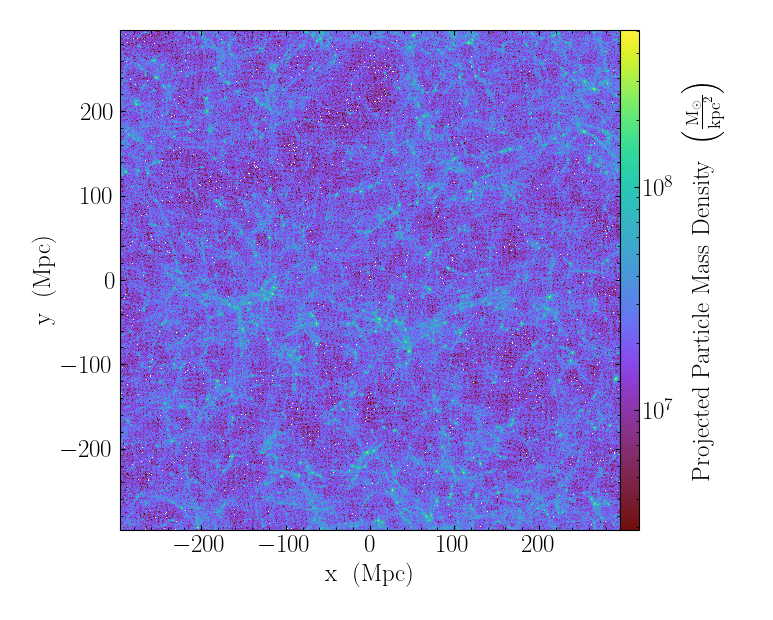

In [7]:
# plot the density map
p = yt.ParticlePlot(ds,'particle_position_x','particle_position_y','particle_mass',density=True)
p.set_figure_size((5,5))
p.set_buff_size(512)
p.set_unit('particle_mass', "Msun/kpc**2")
p.show()

#### 3.1.2. We construct the density map ourselves with numpy 

In [8]:
# extract coordinates and masses of particles 
px = ds.all_data()['particle_position_x'].to('Mpc').value
py = ds.all_data()['particle_position_y'].to('Mpc').value
pm = ds.all_data()['particle_mass'].to('Msun').value
# define the range of the image (in Mpc)
xmin = ds.domain_left_edge[0].to('Mpc').value
xmax = ds.domain_right_edge[0].to('Mpc').value
ymin = ds.domain_left_edge[1].to('Mpc').value
ymax = ds.domain_right_edge[1].to('Mpc').value
# define the resolution of the image (nb of pixels on a side)
npix = 512

# compute the mass in each pixel (2d histogram)
h,xe,ye = np.histogram2d(px,py,weights=pm,bins=(npix,npix),range=[[xmin,xmax],[ymin,ymax]])
# divide by area of pixels 
dx, dy = (xe[1]-xe[0])*1e3, (ye[1]-ye[0])*1e3 # [kpc]
h = h / dx / dy  # [Msun / kpc^2]

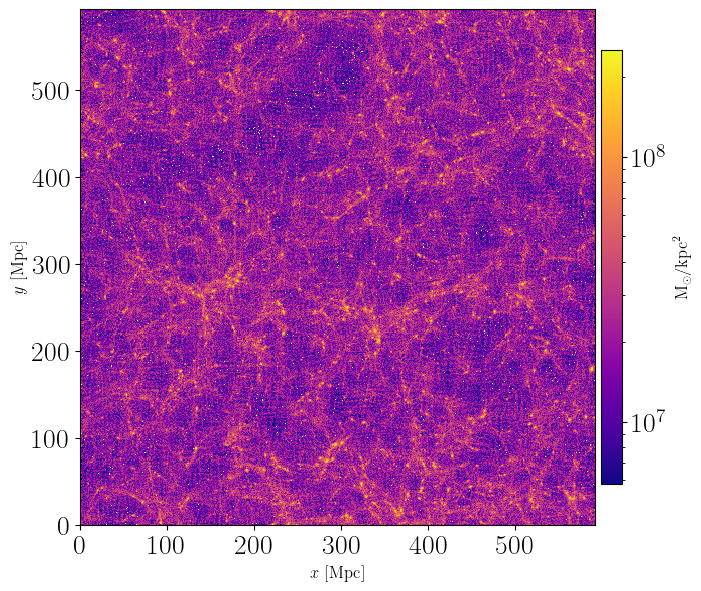

In [9]:
plt.figure(figsize=(7,7))
plt.imshow(h.T,origin='lower',norm=LogNorm(vmax=h.max()/2.,vmin=h[h>0].min()*2),interpolation='none',cmap='plasma',\
          extent=(xmin,xmax,ymin,ymax))
plt.xlabel(r'$x\ [{\rm Mpc}]$',fontsize=12)
plt.ylabel(r'$y\ [{\rm Mpc]}$',fontsize=12)
cb = plt.colorbar(location='right',fraction=0.04,pad=0.01)
cb.set_label(r'${\rm M}_\odot / {\rm kpc}^2$',fontsize=12)

As you can see, both methods yield very similar results, with projected densities ranging from a few times $10^6\,{\rm M}_\odot / {\rm kpc}^2$ to a few times $10^8\,{\rm M}_\odot / {\rm kpc}^2$. In both cases, the "white dots" indicate pixels no particles have been found (i.e., low densities). This is an artefact of the relatively coarse resolution that we have used for the simulation.

#### 3.1.3. Map of the gravitational potential in a plane going through the centre of the box

Aside from the density, we can explore the spatial distribution of other quantities, like the gravitational potential. This can be helpful to understand the dynamics of the large-scale structure and the formation of overdensities and voids. In the next cell, we create a "slice" map of the potential through the centre of the box.


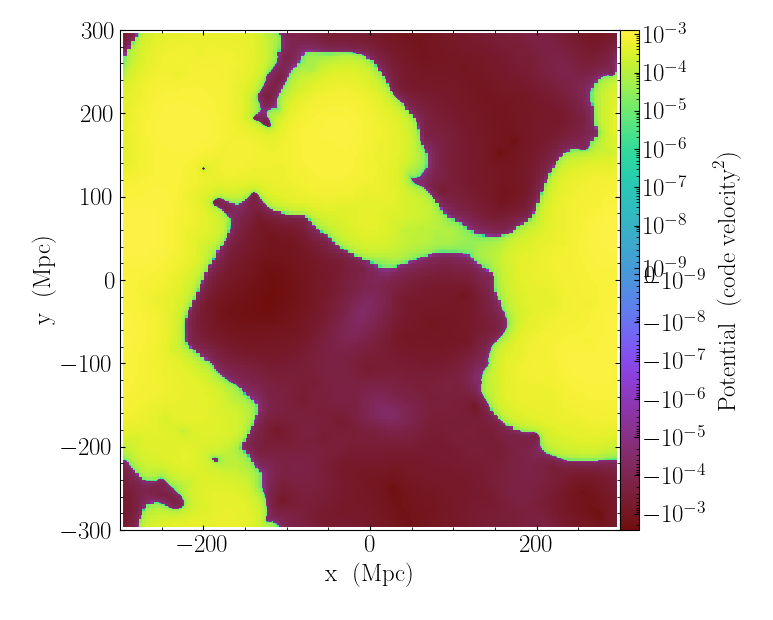

In [10]:
q1 = yt.SlicePlot(ds, "z",('gravity', 'Potential'), width=(600,'Mpc'),center=[0.5, 0.5, 0.5])
# q1.annotate_cell_edges()  # Uncomment to mark the edges of cells
q1.set_figure_size((5,5))
q1.set_buff_size(512)
q1.show()

The most gravitationnaly bound objects in the simulation have negative potential, indicating that matter collapses towards these overdensities.
Conversely, large positive values of the potential signals voids, that act as "repellant".

This can be confirmed visually by inspecting the mesh structure: for this, re-run the previous cell with the `q1.annotate_cell_edges()` line uncommented.

### 3.2. Dark matter halos 

Beyond the large-scale distribution of matter, cosmological simulations can be used to look at dark matter halos, either to study their global distributions or to focus on the properties of individual objects.

#### 3.2.1. Halo detection 

Working with halos requires a specific step to *identify* them: there exist a whole literature on the right method to do this, but for simplicity, we will use the friends-of-friends (FOF) algorithm implemented in `yt_astro_analysis`.

NB: The cell below actually runs the halo detection and may take time. If this has run once, you may skip the loading the halos one cell below. 

In [11]:
# identify Halos with yt's FOF halo finder. 
hc   = HaloCatalog(data_ds=ds, finder_method='fof', output_dir='MyFirstCosmoSim/DarkMatterRun/Halos')
hc.create()

The cell above should have created a halo catalog file `MyFirstCosmoSim/DarkMatterRun/Halos/info_00003/info_00003.0.h5`. We now load this file and overplot halos on the DM density map.

In [12]:
# we now load the halo catalog
hds = yt.load('MyFirstCosmoSim/DarkMatterRun/Halos/info_%5.5i/info_%5.5i.0.h5'%(snap,snap))
hc  = HaloCatalog(data_ds=ds,halos_ds=hds)


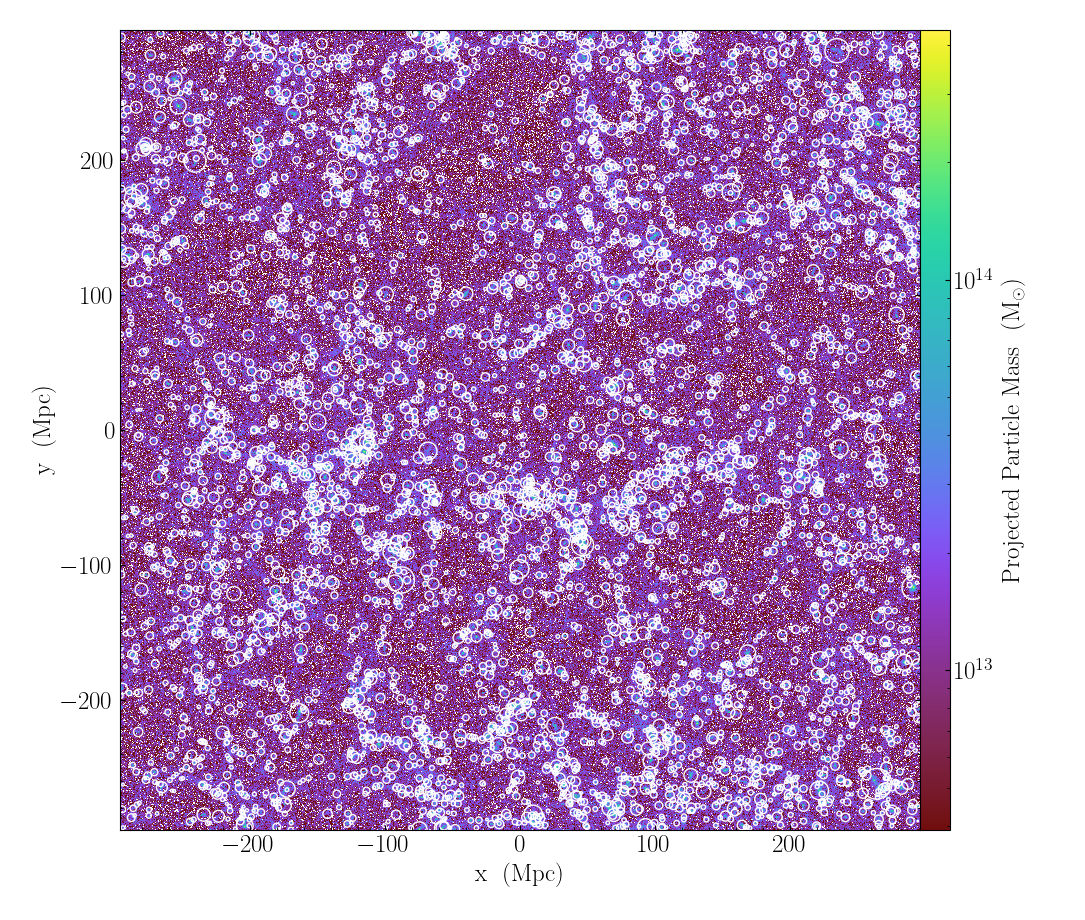

In [13]:
# and plot halos as circles on top of a mass map
p = yt.ParticlePlot(ds,'particle_position_x','particle_position_y','particle_mass')
p.set_unit('particle_mass', 'Msun')
p.annotate_halos(hc)

#### 3.2.2. Make a density map of the most massive halo

As indicated previously, we can look at individual halos in the simulation. We show this here by creating a map of the dark matter density around the most massive halo in the simulation.


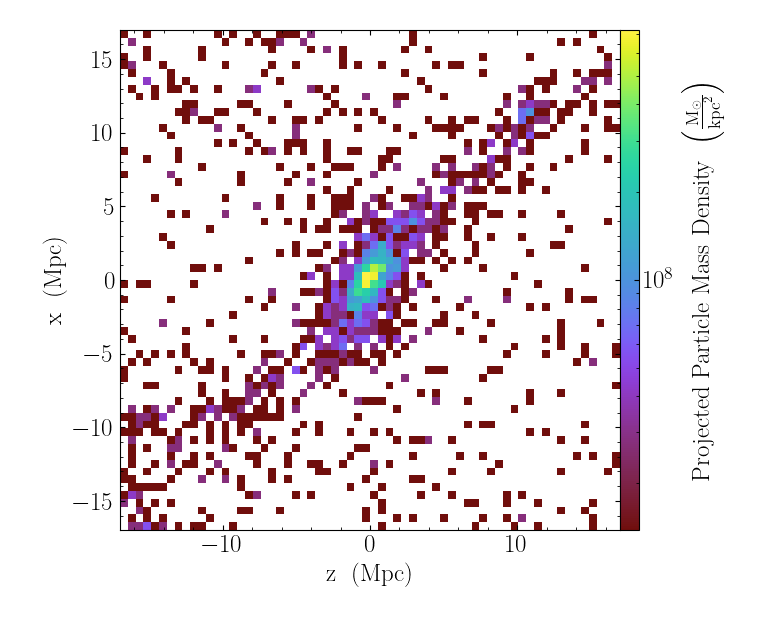

In [14]:
ad    = hds.all_data()
# select most massive halo 
haloM = ad["halos", "particle_mass"].to("Msun")
maxHaloID = np.where(haloM == haloM.max())[0][0]
halo = hds.halo("halos", maxHaloID)
center_halo=ad["halos", "particle_position"][maxHaloID]
rvir = 4 * ad["halos","virial_radius"][maxHaloID]  
p = yt.ParticlePlot(ds,'particle_position_x','particle_position_z','particle_mass',
                       center=center_halo,width=rvir,depth=rvir,axes_unit='Mpc',density=True) 
p.set_unit('particle_mass', "Msun/kpc**2")
p.set_buff_size(64)
p.set_figure_size((5,5))
p.show()

#### 3.2.3. Show stream lines around the most massive halo

As we have seen with the map of the gravitational potential earlier, the density distribution determines the global dynamics. We can show this more directly by overplotting the velocity field (using stream lines, for example) on the density map around the halo.


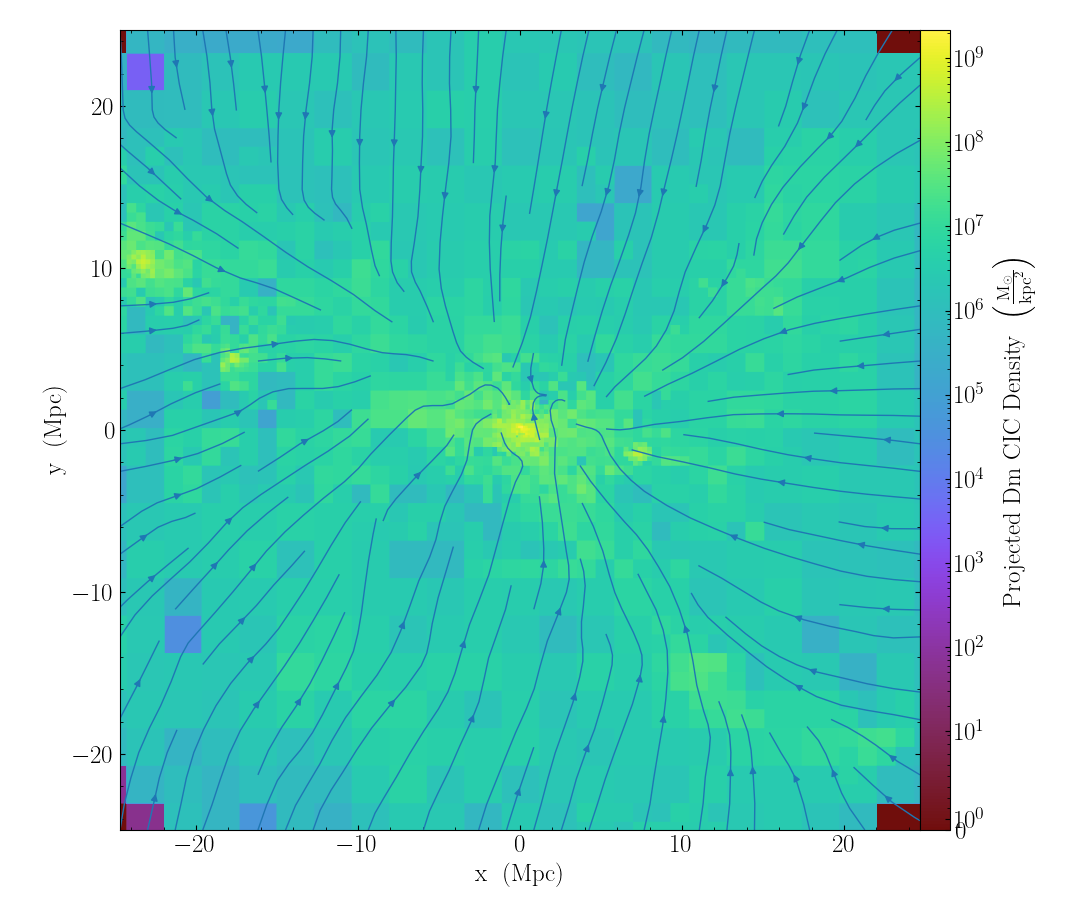

In [15]:
sphere = ds.sphere(center_halo,rvir)
sphere.set_field_parameter("bulk_velocity",ad["halos","particle_velocity"][maxHaloID])

ds.add_deposited_particle_field(("DM", "relative_particle_velocity_x"),method="cic")
ds.add_deposited_particle_field(("DM", "relative_particle_velocity_y"),method="cic")
ds.add_deposited_particle_field(("DM", "relative_particle_velocity_z"),method="cic")

slc = yt.ProjectionPlot(ds, "z", ('deposit', 'DM_cic'), center=center_halo,data_source=sphere)
slc.annotate_streamlines(('deposit', 'DM_cic_relative_velocity_x'), ('deposit', 'DM_cic_relative_velocity_y'))
slc.zoom(12)
slc.set_unit(('deposit', 'DM_cic'), "Msun/kpc**2")
slc.show()

#### 3.2.4 Halo mass function

In this next section, we compute the halo mass function in the simulation at $z=0$, and compare it to theoretical expectations.

In [16]:
# extract halo masses (in Msun units)
halo_masses = hc.halos_ds.all_data()['particle_mass'].to('Msun')

In [17]:
# Compute the simulation volume in comoving Mpc
SimVolume_proper = ds.domain_width[0].to('Mpc')**3
SimVolume_comov  = SimVolume_proper / ds.parameters['aexp']**3 

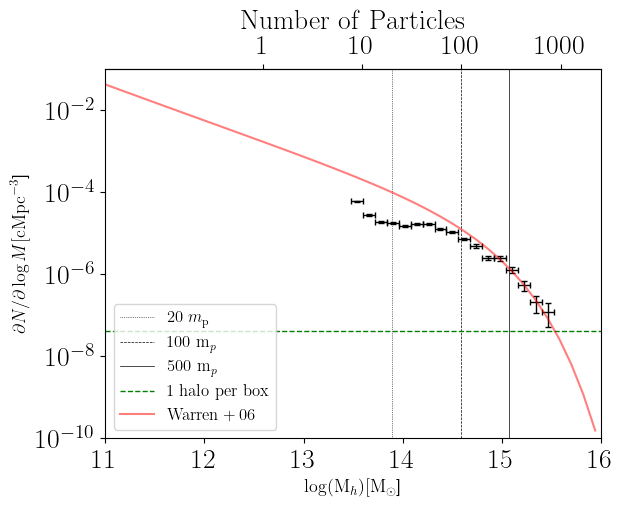

In [18]:
# Compute the mass function
fig, ax = plt.subplots()
h,xe = np.histogram(np.log10(halo_masses),bins=50,range=(10,16))
xmid = 0.5*(xe[:-1]+xe[1:]) # center of bins [Msun]
dh   = np.sqrt(h) # Poisson noise
normalisation = 1. / SimVolume_comov.value / (xmid[1]-xmid[0])
h    = h * normalisation   # nb of halos per cMpc^3 per dLogM
dh   = dh * normalisation 

pmass=(ds.all_data()['particle_mass'][0].to('Msun').value)

# plot the HMF with Poisson error bars
plt.errorbar(xmid,h,yerr=dh,xerr=0.5*(xmid[1]-xmid[0]),elinewidth=1,capsize=2,
             ecolor='k',linestyle='none')
# add vertical lines marking 20,100, and 500 times the particle mass in the simulation
ax.axvline(np.log10(20*pmass),ls=':',c='k',lw=.5,label=r'$20\ m_{\rm p}$')
ax.axvline(np.log10(100*pmass),ls='--',c='k',lw=.5,label=r'$100\ {\rm m}_p$')
ax.axvline(np.log10(300*pmass),ls='-',c='k',lw=0.5,label=r'$500\ {\rm m}_p$')
# add a horizontal line marking the density corresponding to 1 halo in the simulation
ax.axhline(normalisation,color='g',lw=1,ls='--',label=r'${\rm 1\ halo\ per\ box}$')

#add a second axis to show the number of particles
def logM_to_log_particles(logM):
    """ Convert halo mass (log scale) to number of particles (log scale). """
    particles = 10**logM / pmass
    return np.log10(particles)
def log_particles_to_logM(logN):
    """ Convert number of particles (log scale) to halo mass (log scale). """
    return np.log10(10**logN * pmass)

secax = ax.secondary_xaxis('top', functions=(logM_to_log_particles, log_particles_to_logM))
particle_ticks_log = [0, 1, 2, 3, 4]  
particle_ticks = [10**tick for tick in particle_ticks_log] 
secax.set_xticks(particle_ticks_log)
secax.set_xticklabels([r'${}$'.format(int(tick)) for tick in particle_ticks])
secax.set_xlabel(r'${\rm Number\ of\ Particles}$')

# make the plot pretty
plt.xlim(11,16)
plt.ylim(1e-10,1e-1)
plt.xlabel(r'$ \log({\rm M}_h) [ {\rm M}_\odot$]',fontsize=13)
plt.ylabel(r'$\partial N/ \partial \log M [{\rm cMpc}^{-3}$]',fontsize=13)
plt.yscale('log')

# Add models from Collossus 
from colossus.lss import mass_function
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
little_h = cosmology.current_cosmo.H0/100.
redshift = ds.current_redshift
HMF_T = mass_function.massFunction(10.**xmid*little_h, redshift, mdef = 'fof', model = 'warren06',q_out = 'dndlnM')
plt.plot(xmid, HMF_T,label=r"${\rm Warren+06}$",c='r',alpha=0.5)
hush  = plt.legend(fontsize=12,loc='lower left')

Notice on the plot above how the simulation deviates from theoretical expectations (or actually fits from higher-resolution simulations) at low masses. Halos with less than a few 100 particles are affected by resolution and their population is incomplete, which leads to a systematic under-estimation of the halo mass function. 

## 4. More fun. 

Here we suggest exercises to explore various aspects of cosmological simulations. 

1. **Cosmic variance**. Run simulations on ICs generated with different seeds. Measure the halo mass function and see how it changes. 

2. **Random seeds**. It is also instructive to run simulations which share the same realisation of density fluctuations on large scales, but that differ on small scales. This can be done easily with MUSIC's `[random]` section in the configuration file. Try generating ICs with seed[7]=12345, and different values for seed[8] (and higher). Run the simulations and discuss.

3. **Resolution effects**. The mass resolution (particle mass) has a strong impact on the population of DM halos that form in a simulation. While it is not practical to increase the number of particles here, we can instead change the volume of the simulation to probe this effect. Run simulations with a fixed number of particles and different volumes. Plot the halo mass functions to compare them. 

4. **DM concentration**. Dark matter is dissipationless and will thus not condense into arbitrary large densities. You can see this by running RAMSES simulations with different values of `levelmax`. Try a very large value (e.g. 20) and see if the simulation reaches that. Careful, though, if you turn on dissipative hydro, the gas *will* collapse as far as you allow. 

5. **Adding gas...** Run an adiabatic simulation with gas. And one with cooling turned on (but no SF?). 
